In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from operator import attrgetter
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns

In [ ]:
df = pd.read_excel('/content/onlineretail.xlsx')
data = df.copy()

# Initial Exploratory Data Analysis (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
print("Samples:", df.shape[0])
print("Features:", df.shape[1])

Samples: 541909
Features: 8


In [ ]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
missing_values = df.isnull().sum()
print('Missing Values:\n', missing_values)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
duplicate_count = df.duplicated().sum()
print('Duplicate_count: ', duplicate_count)

Duplicate_count:  5268


In [ ]:
dec = df.columns.drop('CustomerID')
df[dec].describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


#### Findings:

* The dataset has 8 attributes: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country.

* There are gaps in the data for the Description and CustomerID fields.

* Missing Values:
  * Description: 1454 gaps.
  * CustomerID: 135080 gaps (approximately 24.9 percent of the sample).
    
* Duplicates: 5268 duplicate rows.

#### Handeling Missing Values

In [ ]:
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"Number of outliers in '{column}': {len(outliers)}")

Number of outliers in 'Quantity': 58619
Number of outliers in 'UnitPrice': 39627
Number of outliers in 'CustomerID': 0


In [ ]:
df.drop_duplicates(inplace=True)
df['Description'].fillna('Unknown', inplace=True)
df["CustomerID"] = df["CustomerID"].astype(str).replace("nan", "Unknown_Customer")
df.isnull().sum()

<ipython-input-10-74149fe5eaf5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Unknown', inplace=True)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = df[df["Quantity"] >= 0]
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day
df["Weekday"] = df["InvoiceDate"].dt.weekday

<ipython-input-11-25b990a81a65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["InvoiceDate"].dt.year
<ipython-input-11-25b990a81a65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df["InvoiceDate"].dt.month
<ipython-input-11-25b990a81a65>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

# Pareto Analysis (80-20 Rule)

### Product-Based Pareto Analysis

In [ ]:
#pareto graph
revenue_per_product = df.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False)
cumulative_share = revenue_per_product.cumsum() / revenue_per_product.sum()
threshold_80 = (cumulative_share <= 0.80).sum()
total_unique_products = df['StockCode'].nunique()

print(f"Total Products: {total_unique_products}")
print(f"Products contributing to 80% of revenue: {threshold_80} ({(threshold_80 / total_unique_products) * 100:.2f}%)")
plt.figure(figsize=(10, 5))
x_vals = np.arange(1, len(cumulative_share) + 1) / len(cumulative_share)
plt.plot(x_vals, cumulative_share, marker='o', linestyle='-')
plt.axhline(0.80, color='red', linestyle='--', label='80% Revenue Threshold')
plt.axvline(threshold_80 / total_unique_products, color='green', linestyle='--', label=f"{(threshold_80 / total_unique_products):.2%} Products")
plt.title("Pareto Analysis of Product Revenue")
plt.xlabel("Cumulative Share of Products")
plt.ylabel("Cumulative Share of Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

#### Top Products:

Here are top 10 revenue generating products.

In [ ]:
revenue_per_product.head(10)

,Revenue
StockCode,
DOT,206248.77
22423,174156.54
23843,168469.60
85123A,104462.75
47566,99445.23
85099B,94159.81
23166,81700.92
POST,78101.88
M,77750.27


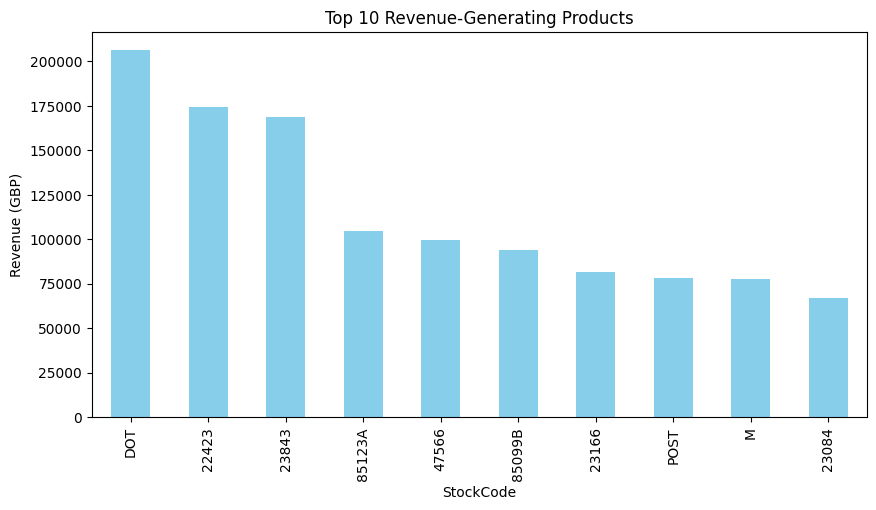

In [ ]:
top_products = revenue_per_product.head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='skyblue', title='Top 10 Revenue-Generating Products')
plt.ylabel("Revenue (GBP)")
plt.show()

## Customer-Based Pareto Analysis

Total Customers: 4340
Customers contributing to 80% of revenue: 932 (21.47%)


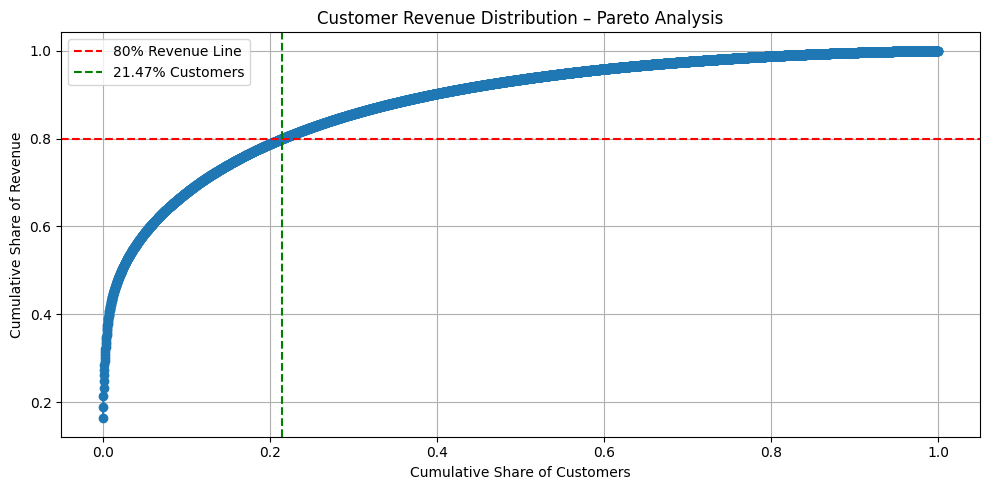

In [ ]:
revenue_by_customer = df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False)
cumulative_revenue_ratio = revenue_by_customer.cumsum() / revenue_by_customer.sum()
top_80_customers = (cumulative_revenue_ratio <= 0.80).sum()
total_unique_customers = df['CustomerID'].nunique()
print(f"Total Customers: {total_unique_customers}")
print(f"Customers contributing to 80% of revenue: {top_80_customers} "
      f"({(top_80_customers / total_unique_customers) * 100:.2f}%)")
plt.figure(figsize=(10, 5))
x_axis = np.arange(1, len(cumulative_revenue_ratio) + 1) / len(cumulative_revenue_ratio)
plt.plot(x_axis, cumulative_revenue_ratio, marker='o', linestyle='-')
plt.axhline(0.80, color='red', linestyle='--', label='80% Revenue Line')
plt.axvline(top_80_customers / total_unique_customers, color='green', linestyle='--',
            label=f'{(top_80_customers / total_unique_customers):.2%} Customers')
plt.title("Customer Revenue Distribution – Pareto Analysis")
plt.xlabel("Cumulative Share of Customers")
plt.ylabel("Cumulative Share of Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Top Customers:

Here are top 10 Customers who contribute most to revenue.

In [ ]:
revenue_by_customer.head(10)

,Revenue
CustomerID,
Unknown_Customer,1732777.79
14646.0,280206.02
18102.0,259657.30
17450.0,194390.79
16446.0,168472.50
14911.0,143711.17
12415.0,124914.53
14156.0,117210.08
17511.0,91062.38


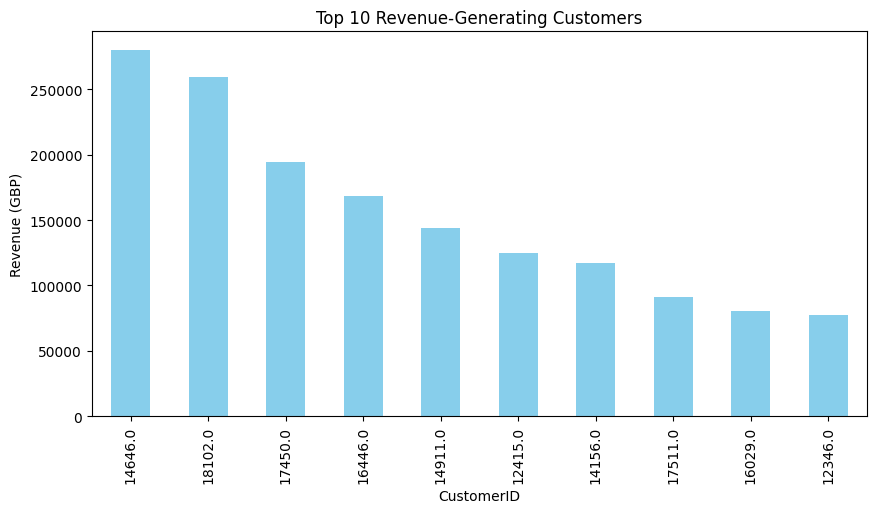

In [ ]:
top_customers = revenue_by_customer.iloc[1:].head(10)
plt.figure(figsize=(10,5))
top_customers.plot(kind='bar', color='skyblue', title='Top 10 Revenue-Generating Customers')
plt.ylabel("Revenue (GBP)")
plt.show()

In [ ]:
revenue_by_customer

,Revenue
CustomerID,
Unknown_Customer,1732777.79
14646.0,280206.02
18102.0,259657.30
17450.0,194390.79
16446.0,168472.50
...,...
17956.0,12.75
16454.0,6.90
14792.0,6.20


# Return Analysis

In [ ]:
df = data.copy()
df['Description'].fillna('Unknown', inplace=True)
df["CustomerID"] = df["CustomerID"].astype(str).replace("nan", "Unknown_Customer")
df['Revenue_lost'] = df['Quantity'] * df['UnitPrice']
df_returns = df[df["Quantity"] < 0]
df_returns['Quantity'] = df_returns['Quantity'] * (-1)
df_returns['Revenue_lost'] = df_returns['Revenue_lost'] * (-1)

df_returns.info()

<ipython-input-19-d882b96138dc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna('Unknown', inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 10624 entries, 141 to 541717
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     10624 non-null  object        
 1   StockCode     10624 non-null  object        
 2   Description   10624 non-null  object        
 3   Quantity      10624 non-null  int64         
 4   InvoiceDate   10624 non-null  datetime64[ns]
 5   UnitPrice     10624 non-null  float64       
 6   CustomerID    10624 non-null  object        
 7   Country       10624 non-null  object        
 8   Revenue_lost  10624 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 830.0+ KB


<ipython-input-19-d882b96138dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['Quantity'] = df_returns['Quantity'] * (-1)
<ipython-input-19-d882b96138dc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns['Revenue_lost'] = df_returns['Revenue_lost'] * (-1)


In [ ]:
df_returns.describe()

,Quantity,InvoiceDate,UnitPrice,Revenue_lost
count,10624.000000,10624,10624.000000,10624.000000
mean,45.607210,2011-06-24 19:32:09.346761984,42.308012,84.413826
min,1.000000,2010-12-01 09:41:00,0.000000,0.000000
25%,1.000000,2011-03-24 11:23:15,1.060000,2.100000
50%,2.000000,2011-07-04 15:57:00,2.100000,6.800000
75%,10.000000,2011-10-06 19:52:00,4.950000,15.950000
max,80995.000000,2011-12-09 11:58:00,38970.000000,168469.600000
std,1092.214216,NaN,623.481552,1907.591425


In [ ]:
print('Total Sales Revenue:', df['Revenue_lost'].sum())
print('Total Return Revenue:', df_returns['Revenue_lost'].sum())

Total Sales Revenue: 9747747.933999998
Total Return Revenue: 896812.49


#### Identify Products with High Return Counts
We'll count how many times each product was returned and sort them to find the most frequently returned items.

<Figure size 1200x800 with 0 Axes>

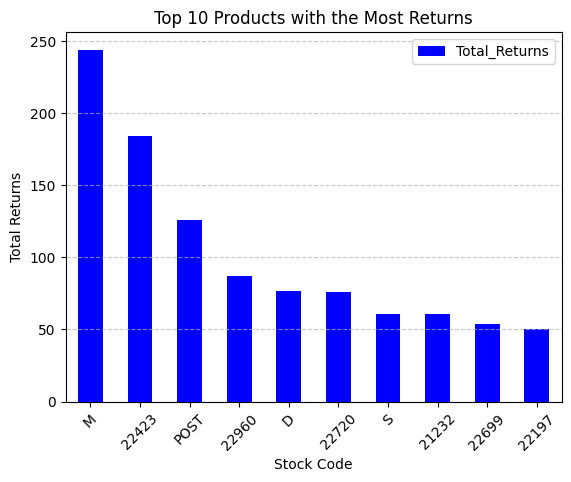

In [ ]:
product_return_counts = df_returns.groupby('StockCode')['Quantity'].count().reset_index()
product_return_counts.rename(columns={'Quantity': 'Total_Returns'}, inplace=True)
top_returned_products = product_return_counts.sort_values(by='Total_Returns', ascending=False)
top_10_returned_products = top_returned_products.head(10)
plt.figure(figsize=(12, 8))
top_10_returned_products.plot(x='Stockcode', y='Total_returns', kind='bar', color='blue')
plt.xlabel("Stock Code")
plt.ylabel("Total Returns")
plt.title("Top 10 Products with the Most Returns")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

####  Identify Customers Who Return the Most
Now that we have identified the most returned products, let's analyze which customers return the most and how frequently.

<Figure size 1200x600 with 0 Axes>

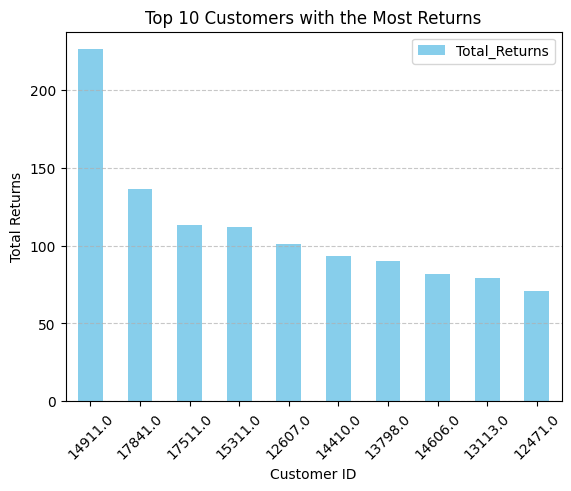

In [ ]:
customer_return_counts = df_returns[df_returns['CustomerID'] != 'Unknown_Customer'].groupby('CustomerID')['Quantity'].count().reset_index()
customer_return_counts.rename(columns={'Quantity': 'Total_Returns'}, inplace=True)
top_returning_customers = customer_return_counts.sort_values(by='Total_Returns', ascending=False)
top_10_customers = top_returning_customers.head(10)
plt.figure(figsize=(12, 6))
top_10_customers.plot(x='CustomerID', y='Total_Returns', kind='bar', color='skyblue')
plt.xlabel("Customer ID")
plt.ylabel("Total Returns")
plt.title("Top 10 Customers with the Most Returns")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Top Products Causing Revenue Loss

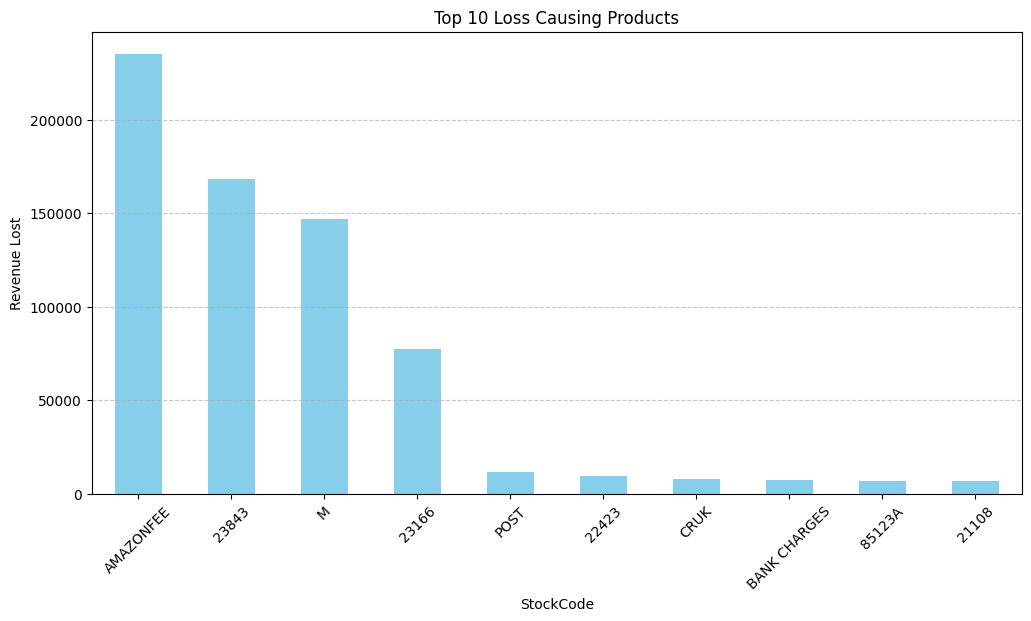

In [ ]:
top_loss_causing_products = df_returns.groupby('StockCode')['Revenue_lost'].sum().sort_values(ascending=False)
top_10_loss_causing_products = top_loss_causing_products.head(10)
plt.figure(figsize=(12, 6))
top_10_loss_causing_products.plot(kind='bar', color='skyblue')
plt.xlabel("StockCode")
plt.ylabel("Revenue Lost")
plt.title("Top 10 Loss Causing Products")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Top Customers Causing Revenue Loss

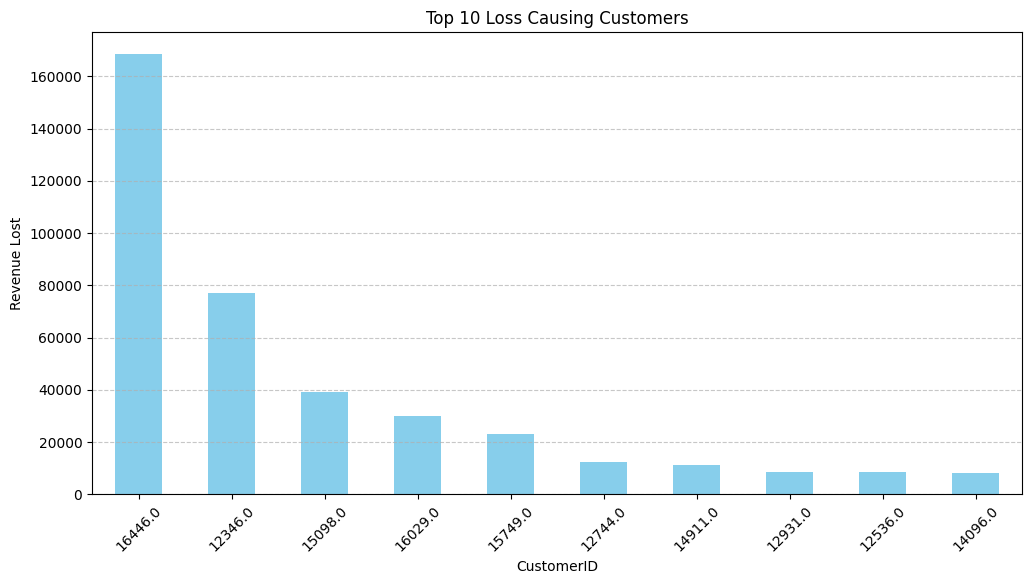

In [ ]:
top_loss_causing_products = df_returns.groupby('CustomerID')['Revenue_lost'].sum().sort_values(ascending=False)
top_10_loss_causing_products = top_loss_causing_products.iloc[1:11]
plt.figure(figsize=(12, 6))
top_10_loss_causing_products.plot(kind='bar', color='skyblue')
plt.xlabel("CustomerID")
plt.ylabel("Revenue Lost")
plt.title("Top 10 Loss Causing Customers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
top_loss_causing_products

,Revenue_lost
CustomerID,
Unknown_Customer,285470.40
16446.0,168469.60
12346.0,77183.60
15098.0,39267.00
16029.0,30032.23
...,...
17164.0,0.95
12421.0,0.77
16566.0,0.65


#### Return Patterns Over Time
Are returns increasing or decreasing over months?
Do returns spike during specific seasons


<Figure size 1200x600 with 0 Axes>

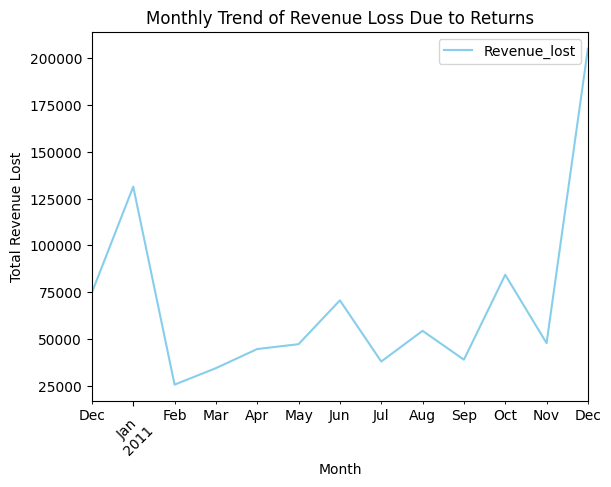

In [ ]:
# Extract month and analyze return trends
df_returns["ReturnMonth"] = df_returns["InvoiceDate"].dt.to_period("M")

# Aggregate revenue lost per month
monthly_return_trend = df_returns.groupby("ReturnMonth")["Revenue_lost"].sum().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
monthly_return_trend.plot(x="ReturnMonth", y="Revenue_lost", kind="line", color="skyblue")
plt.xlabel("Month")
plt.ylabel("Total Revenue Lost")
plt.title("Monthly Trend of Revenue Loss Due to Returns")
plt.xticks(rotation=45)
plt.show()


#### Country-Wise Return Analysis
* Are some countries returning more than others?
* Are international returns higher than domestic ones?


<Figure size 1200x600 with 0 Axes>

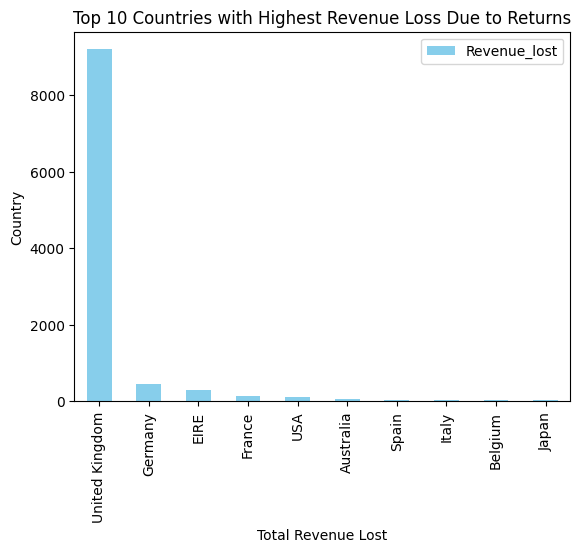

In [ ]:
# Aggregate revenue lost per country
country_return_loss = df_returns.groupby("Country")["Revenue_lost"].count().reset_index()

# Get top 10 countries by revenue loss
top_countries_loss = country_return_loss.sort_values(by="Revenue_lost", ascending=False).head(10)

# Visualization
plt.figure(figsize=(12, 6))
top_countries_loss.plot(x="Country", y="Revenue_lost", kind="bar", color="skyblue")
plt.xlabel("Total Revenue Lost")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest Revenue Loss Due to Returns")
plt.show()

# **1. RFM Analysis – (Customer Segmentation)**

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter out returns (Quantity < 0)
df = df[df['Quantity'] > 0]

# Create 'Revenue' column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Reference date (latest date in data + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM grouping
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

rfm.head()

<ipython-input-29-8695113af24d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Revenue'] = df['Quantity'] * df['UnitPrice']


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [ ]:
# Assign scores from 1 to 4 (quartiles) – higher is better for F & M, lower is better for R
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

# Combine into an RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)


In [ ]:
def assign_rfm_label(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_rfm_label)


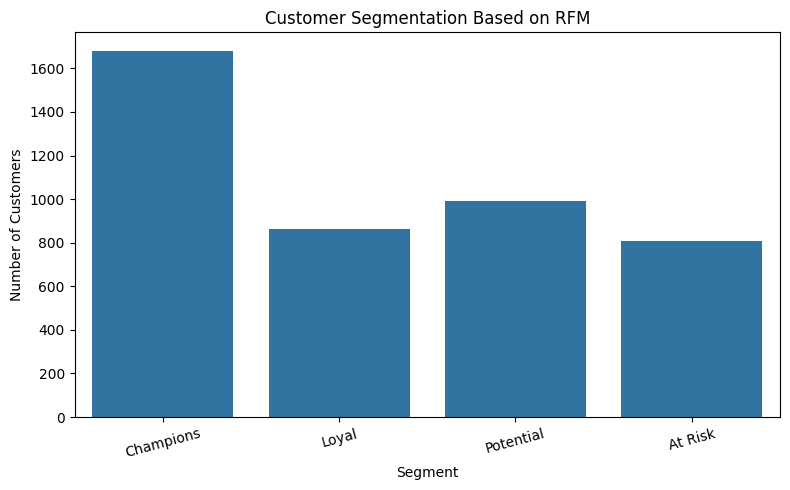

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=['Champions','Loyal','Potential','At Risk'])
plt.title('Customer Segmentation Based on RFM')
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# **2. Market Basket Analysis – (Product Bundling)**

In [ ]:
df_clean = df[
    (df['Country'] == 'United Kingdom') &
    (df['Quantity'] > 0) &
    (df['InvoiceNo'].notnull()) &
    (df['Description'].notnull())
]
sample_invoices = df_clean['InvoiceNo'].drop_duplicates().sample(n=1000, random_state=42)
df_sample = df_clean[df_clean['InvoiceNo'].isin(sample_invoices)]

basket = df_sample.pivot_table(
    index='InvoiceNo',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

item_counts = (basket > 0).sum(axis=0)
basket = basket.loc[:, item_counts[item_counts >= 10].index]

basket = basket.applymap(lambda x: x > 0).astype(bool)

frequent_items = apriori(basket, min_support=0.01, use_colnames=True)

print("Frequent itemsets with 2+ items:")
print(frequent_items[frequent_items['itemsets'].apply(lambda x: len(x) > 1)])

rules = association_rules(frequent_items, metric="confidence", min_threshold=0.2)

print("Top rules:")
print(rules.sort_values('confidence', ascending=False).head())


<ipython-input-34-a6787f4a06da>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: x > 0).astype(bool)


Frequent itemsets with 2+ items:
      support                                           itemsets
852     0.011  (SET OF 3 BUTTERFLY COOKIE CUTTERS, 3 PIECE SP...
853     0.010  (60 TEATIME FAIRY CAKE CASES, 6 RIBBONS RUSTIC...
854     0.010    (HEART OF WICKER SMALL, 6 RIBBONS RUSTIC CHARM)
855     0.010   (6 RIBBONS RUSTIC CHARM, JAM MAKING SET PRINTED)
856     0.010  (JUMBO BAG RED RETROSPOT, 6 RIBBONS RUSTIC CHARM)
...       ...                                                ...
3334    0.010  (JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SU...
3335    0.010  (JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SU...
3336    0.010  (CHARLOTTE BAG VINTAGE ALPHABET , CHARLOTTE BA...
3337    0.010  (CHARLOTTE BAG SUKI DESIGN, RED RETROSPOT CHAR...
3338    0.010  (PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...

[2487 rows x 2 columns]
Top rules:
                                            antecedents  \
3508  (SUKI  SHOULDER BAG, GREEN REGENCY TEACUP AND ...   
6499  (CHARLOTTE BAG VINTAGE ALPH

# **3. Return Analysis – (Reduce Losses from Returns)**

In [ ]:
# Returns = Quantity < 0
returns = data[data['Quantity'] < 0]

top_returns = returns['Description'].value_counts().head(10)

customer_returns = returns.groupby('CustomerID')['Quantity'].sum().sort_values().head(10)
customer_returns

,Quantity
CustomerID,
16446.0,-80995
12346.0,-74215
15838.0,-9361
15749.0,-9014
16029.0,-8060
12931.0,-4627
14607.0,-3768
14911.0,-3335
17949.0,-2975


# **4. Cohort Analysis – (Customer Retention Over Time)**

<Axes: title={'center': 'Monthly Retention Rates'}, xlabel='CohortIndex'>

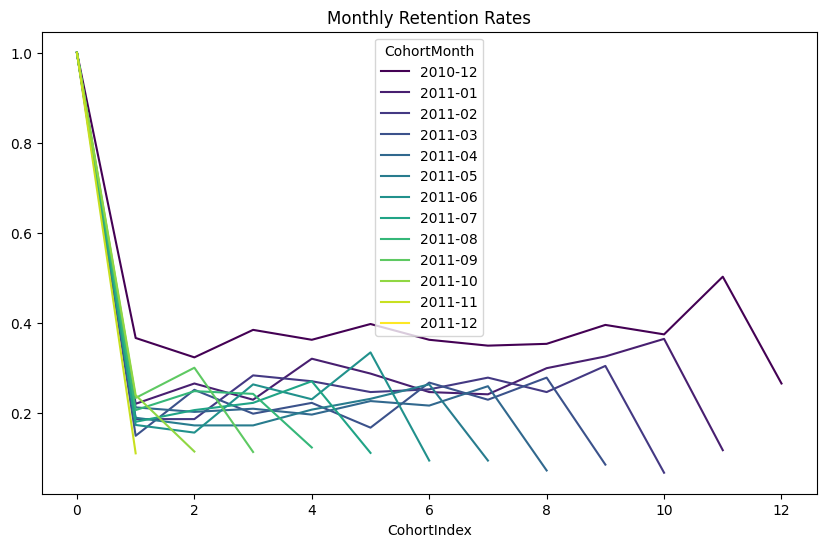

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(attrgetter('n'))

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack(0)
retention = cohort_data.divide(cohort_data.iloc[0], axis=1).round(3)
retention.plot(figsize=(10, 6), cmap='viridis', title='Monthly Retention Rates')


# **1. Customer Lifetime Value (CLV) Estimation**

In [ ]:
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency']
rfm[['Recency', 'Frequency', 'Monetary', 'CLV']].sort_values('CLV', ascending=False).head()

,Recency,Frequency,Monetary,CLV
4339,1,2192,1733152.52,3.799070e+09
1880,1,201,143825.06,2.890884e+07
1690,2,74,280206.02,2.073525e+07
4202,1,60,259657.30,1.557944e+07
3729,8,46,194550.79,8.949336e+06


In [ ]:
country_summary = df.groupby('Country')['Revenue'].agg(['count', 'sum', 'mean']).sort_values('sum', ascending=False)
country_summary

,count,sum,mean
Country,,,
United Kingdom,486286,9003097.964,18.513998
Netherlands,2363,285446.340,120.798282
EIRE,7894,283453.960,35.907520
Germany,9042,228867.140,25.311562
France,8408,209715.110,24.942330
Australia,1185,138521.310,116.895620
Spain,2485,61577.110,24.779521
Switzerland,1967,57089.900,29.023843
Belgium,2031,41196.340,20.283772



# 📌 Final Conclusion

This business data management project used real-world online retail data to derive insights that can directly impact a company’s marketing, inventory, and operational decisions. The following key analyses were performed:

- **EDA & Cleaning**: Identified missing Customer IDs (~25%) and product return indicators (negative quantities), enabling targeted filtering and transformation.
- **RFM Analysis**: Segmented customers based on recency, frequency, and monetary value to identify loyal vs. at-risk buyers.
- **Cohort Analysis**: Tracked customer retention trends by cohort month, uncovering significant drop-offs in later months.
- **Market Basket Analysis**: Applied the Apriori algorithm to discover high-confidence product pairs, suggesting bundling opportunities for increased sales.
- **Return Analysis**: Found frequently returned products and customers contributing to high return volumes—critical for improving quality control.
- **Sales Trend Visualization**: Provided monthly revenue trends to support better forecasting and strategic planning.

These insights form the foundation for data-driven decision-making in customer engagement, inventory management, and product optimization. The methods used are scalable and applicable to real e-commerce businesses aiming to boost retention, profitability, and efficiency.